## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn.model_selection import train_test_split

nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\U6083443\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# first few tagged sentences
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
# Splitting into train and test
random.seed(42)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(f'Length of Training Set: {len(train_set)}')
print(f'Length of Test Set: {len(test_set)}')
print(train_set[:40])

Length of Training Set: 3718
Length of Test Set: 196
[[('She', 'PRON'), ('gives', 'VERB'), ('the', 'DET'), ('Artist', 'NOUN'), ('a', 'DET'), ('sense', 'NOUN'), ('of', 'ADP'), ('purpose', 'NOUN'), (',', '.'), ('but', 'CONJ'), ('also', 'ADV'), ('alerts', 'VERB'), ('him', 'PRON'), ('to', 'PRT'), ('the', 'DET'), ('serious', 'ADJ'), ('inadequacy', 'NOUN'), ('of', 'ADP'), ('his', 'PRON'), ('vagrant', 'ADJ'), ('life', 'NOUN'), ('.', '.')], [('The', 'DET'), ('fact', 'NOUN'), ('that', 'ADP'), ('a', 'DET'), ('vast', 'ADJ'), ('majority', 'NOUN'), ('of', 'ADP'), ('fundamentalist', 'ADJ'), ('money', 'NOUN'), ('managers', 'NOUN'), ('fail', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('beat', 'VERB'), ('the', 'DET'), ('S&P', 'NOUN'), ('500', 'NUM'), ('may', 'VERB'), ('contribute', 'VERB'), ('to', 'PRT'), ('the', 'DET'), ('hysteria', 'NOUN'), ('surrounding', 'VERB'), ('the', 'DET'), ('issue', 'NOUN'), ('.', '.')], [('Spirit', 'NOUN'), ('of', 'ADP'), ('Perestroika', 'X'), ('Touches', 'VERB'), ('Design', 'NOU

In [5]:
 train_tagged_words = [tup for sent in train_set for tup in sent]

In [6]:
len(train_tagged_words)

95855

In [60]:
pos_counts = collections.Counter((subl[1] for subl in train_tagged_words))
print("The five most common tags are", pos_counts.most_common(5))

The five most common tags are [('NOUN', 27470), ('VERB', 12930), ('.', 11091), ('ADP', 9397), ('DET', 8350)]


In [7]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['She', 'gives', 'the', 'Artist', 'a', 'sense', 'of', 'purpose', ',', 'but']

In [8]:
# vocabulary
V = set(tokens)
print(f'Total Words in Vocabulary: {len(V)}')

Total Words in Vocabulary: 12071


In [9]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
print(f'Total Tags : {len(T)}')

Total Tags : 12


### Build the vanilla Viterbi based POS tagger

#### Emission Probabilities

In [10]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [11]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [12]:
print(word_given_tag('Japanese','ADJ'))
print(word_given_tag('Minister','NOUN'))

# book
print("\n", "book")
print(word_given_tag('book', 'NOUN'))
print(word_given_tag('book', 'VERB'))

(76, 6148)
(4, 27470)

 book
(7, 27470)
(1, 12930)


In [13]:
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [14]:
print(t2_given_t1(t2='NOUN', t1='ADJ'))
print(t2_given_t1(t2='NOUN', t1='VERB'))
print(t2_given_t1(t2='PRON', t1='VERB'))

(4296, 6148)
(1419, 12930)
(464, 12930)


In [15]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [16]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df.head(10)

,NUM,PRT,ADP,X,VERB,PRON,.,ADJ,NOUN,DET,ADV,CONJ
NUM,0.184864,0.028118,0.035298,0.207000,0.017649,0.001496,0.117858,0.034400,0.352378,0.003590,0.002991,0.014358
PRT,0.057674,0.001629,0.020854,0.013034,0.400456,0.018247,0.042685,0.084718,0.246008,0.102313,0.010101,0.002281
ADP,0.062786,0.001490,0.017133,0.034905,0.008194,0.068958,0.038842,0.106843,0.321166,0.325104,0.013728,0.000851
X,0.002714,0.185026,0.144317,0.073755,0.206897,0.056354,0.161079,0.017720,0.062261,0.055077,0.025223,0.009579
VERB,0.022738,0.032019,0.091106,0.216937,0.169142,0.035886,0.034725,0.065584,0.109745,0.134803,0.081825,0.005491
PRON,0.007271,0.011864,0.022579,0.093762,0.487179,0.008037,0.041332,0.075392,0.204746,0.009568,0.033678,0.004592
.,0.079344,0.002525,0.092237,0.027139,0.090163,0.066270,0.092057,0.045532,0.219457,0.175097,0.052565,0.057524
ADJ,0.020657,0.010898,0.077586,0.020982,0.012362,0.000651,0.064411,0.067176,0.698764,0.005042,0.004554,0.016916
NOUN,0.009246,0.043793,0.176993,0.028941,0.146414,0.004769,0.239607,0.012304,0.264543,0.013360,0.017328,0.042701
DET,0.022395,0.000240,0.009581,0.045509,0.039401,0.003593,0.017725,0.204431,0.638323,0.005509,0.012814,0.000479


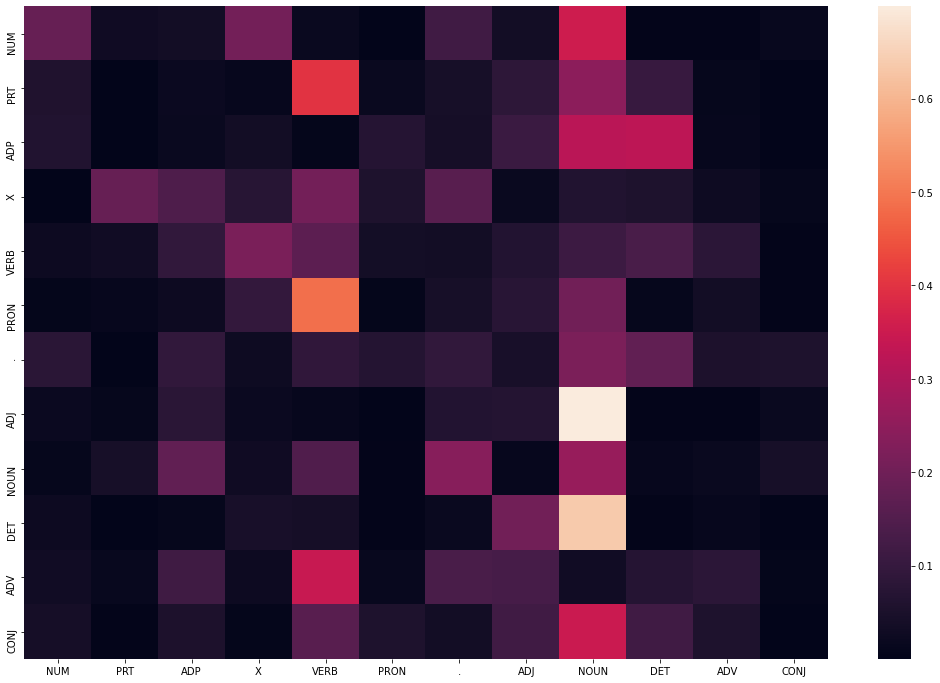

In [17]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

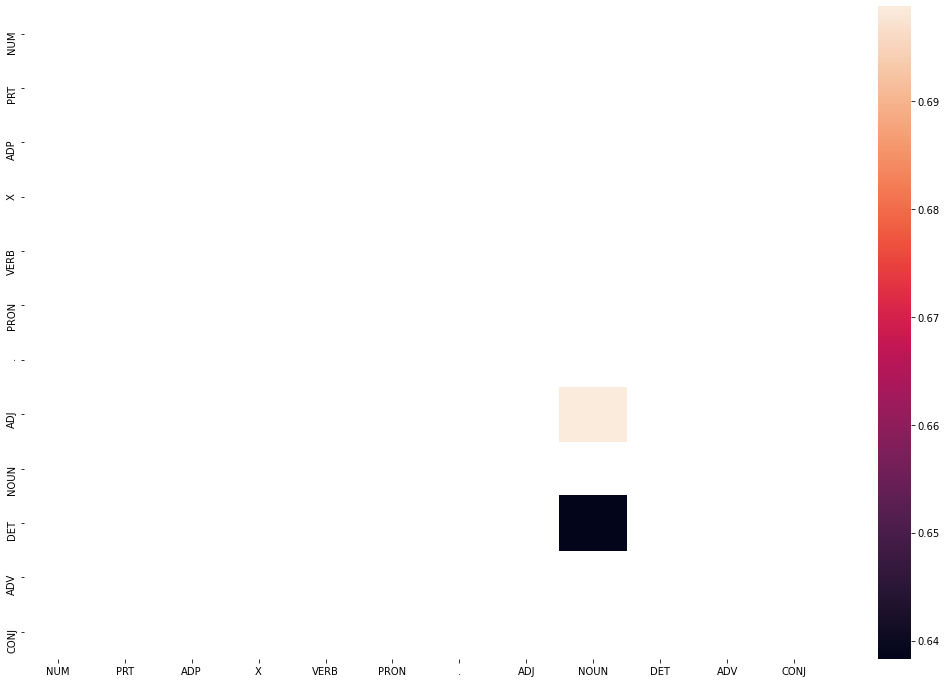

In [18]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [19]:
import functools
import time
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        start = time.time()
        value = func(*args, **kwargs)
        print(f'{func.__name__} processsing finished in {time.time()-start} seconds')
        return value 
    wrapper_timer._original = func
    return wrapper_timer

# Viterbi Heuristic
@timer
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [20]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(42)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('Payments', 'NOUN'),
  ('are', 'VERB'),
  ('expected', 'VERB'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('range', 'VERB'),
  ('between', 'ADP'),
  ('$', '.'),
  ('9', 'NUM'),
  ('billion', 'NUM'),
  ('*U*', 'X'),
  ('and', 'CONJ'),
  ('$', '.'),
  ('12', 'NUM'),
  ('billion', 'NUM'),
  ('*U*', 'X'),
  ('this', 'DET'),
  ('year', 'NOUN'),
  ('.', '.')],
 [('The', 'DET'),
  ('board', 'NOUN'),
  ('is', 'VERB'),
  ('dominated', 'VERB'),
  ('*-41', 'X'),
  ('by', 'ADP'),
  ('the', 'DET'),
  ('heirs', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('late', 'ADJ'),
  ('John', 'NOUN'),
  ('T.', 'NOUN'),
  ('Dorrance', 'NOUN'),
  ('Jr.', 'NOUN'),
  (',', '.'),
  ('who', 'PRON'),
  ('*T*-31', 'X'),
  ('controlled', 'VERB'),
  ('about', 'ADP'),
  ('58', 'NUM'),
  ('%', 'NOUN'),
  ('of', 'ADP'),
  ('Campbell', 'NOUN'),
  ("'s", 'PRT'),
  ('stock', 'NOUN'),
  ('when', 'ADV'),
  ('he', 'PRON'),
  ('died', 'VERB'),
  ('in', 'ADP'),
  ('April', 'NOUN'),
  ('*T*-1', 'X'),
  ('.', '.')],
 [('Heating', 'NOU

In [21]:
# tagging the test sentences
tagged_seq = Viterbi(test_tagged_words)

Viterbi processsing finished in 15.084974765777588 seconds


In [22]:
tagged_seq[:10]

[('Payments', 'NUM'),
 ('are', 'VERB'),
 ('expected', 'VERB'),
 ('*-1', 'X'),
 ('to', 'PRT'),
 ('range', 'NOUN'),
 ('between', 'ADP'),
 ('$', '.'),
 ('9', 'NUM'),
 ('billion', 'NUM')]

In [23]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
print(f'Accuracy using Vanilla Viterbi Algorithm on Test Set: {len(check)/len(tagged_seq)}')

Accuracy using Vanilla Viterbi Algorithm on Test Set: 0.9148936170212766


In [24]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('.', '.'), (('Payments', 'NUM'), ('Payments', 'NOUN'))],
 [('to', 'PRT'), (('range', 'NOUN'), ('range', 'VERB'))],
 [('the', 'DET'), (('heirs', 'NUM'), ('heirs', 'NOUN'))],
 [('.', '.'), (('Heating', 'NUM'), ('Heating', 'NOUN'))],
 [('.', '.'), (('Video', 'NUM'), ('Video', 'NOUN'))],
 [('Video', 'NOUN'), (('Tip', 'NUM'), ('Tip', 'NOUN'))],
 [('his', 'PRON'), (('finest', 'NUM'), ('finest', 'ADJ'))],
 [('El', 'NOUN'), (('Paso', 'NUM'), ('Paso', 'NOUN'))],
 [('Western', 'ADJ'), (('boots', 'NUM'), ('boots', 'NOUN'))],
 [('and', 'CONJ'), (('leather', 'NUM'), ('leather', 'NOUN'))],
 [('the', 'DET'), (('preferred', 'ADJ'), ('preferred', 'VERB'))],
 [('would', 'VERB'), (('accrue', 'NUM'), ('accrue', 'VERB'))]]

In [25]:
wrong_tagged_words = [j[0][0] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]
wrong_tagged_words

['Payments',
 'range',
 'heirs',
 'Heating',
 'Video',
 'Tip',
 'finest',
 'Paso',
 'boots',
 'leather',
 'preferred',
 'accrue']

## Test Sentences

In [26]:
# load test sentences
test_sentences_df = pd.read_csv('https://cdn.upgrad.com/UpGrad/temp/9dca5f3b-53c3-47e1-86d5-5ec5dafad6f0/Test_sentences.txt',header=None, delimiter='\n',names=  ['sentences'])
test_sentences_df

,sentences
0,Android is a mobile operating system developed...
1,Android has been the best-selling OS worldwide...
2,Google and Twitter made a deal in 2015 that ga...
3,Twitter is an online news and social networkin...
4,"Before entering politics, Donald Trump was a d..."
5,The 2018 FIFA World Cup is the 21st FIFA World...
6,This is the first World Cup to be held in East...
7,Show me the cheapest round trips from Dallas t...
8,I would like to see flights from Denver to Phi...
9,Show me the price of the flights leaving Atlan...


In [27]:
test_sentences_df['tokenized'] = test_sentences_df.sentences.apply(nltk.word_tokenize)

In [28]:
test_sentences_df['tagged'] = test_sentences_df.tokenized.apply(Viterbi._original)

In [29]:
test_sentences_df

,sentences,tokenized,tagged
0,Android is a mobile operating system developed...,"[Android, is, a, mobile, operating, system, de...","[(Android, NUM), (is, VERB), (a, DET), (mobile..."
1,Android has been the best-selling OS worldwide...,"[Android, has, been, the, best-selling, OS, wo...","[(Android, NUM), (has, VERB), (been, VERB), (t..."
2,Google and Twitter made a deal in 2015 that ga...,"[Google, and, Twitter, made, a, deal, in, 2015...","[(Google, NUM), (and, CONJ), (Twitter, NUM), (..."
3,Twitter is an online news and social networkin...,"[Twitter, is, an, online, news, and, social, n...","[(Twitter, NUM), (is, VERB), (an, DET), (onlin..."
4,"Before entering politics, Donald Trump was a d...","[Before, entering, politics, ,, Donald, Trump,...","[(Before, ADP), (entering, VERB), (politics, N..."
5,The 2018 FIFA World Cup is the 21st FIFA World...,"[The, 2018, FIFA, World, Cup, is, the, 21st, F...","[(The, DET), (2018, NUM), (FIFA, NUM), (World,..."
6,This is the first World Cup to be held in East...,"[This, is, the, first, World, Cup, to, be, hel...","[(This, DET), (is, VERB), (the, DET), (first, ..."
7,Show me the cheapest round trips from Dallas t...,"[Show, me, the, cheapest, round, trips, from, ...","[(Show, NOUN), (me, PRON), (the, DET), (cheape..."
8,I would like to see flights from Denver to Phi...,"[I, would, like, to, see, flights, from, Denve...","[(I, PRON), (would, VERB), (like, ADP), (to, P..."
9,Show me the price of the flights leaving Atlan...,"[Show, me, the, price, of, the, flights, leavi...","[(Show, NOUN), (me, PRON), (the, DET), (price,..."


In [34]:
# set(np.concatenate(test_sentences_df.tokenized))
# set(test_sentences_df.tokenized.sum())

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [47]:
# count of words vs tags from test file
test_words = set(np.concatenate(test_sentences_df.tokenized))
word_tag_count = [(word, tag, word_given_tag(word, tag)[0]) for word in test_words for tag in T]
word_tag_count_df = pd.DataFrame.from_records(word_tag_count, columns=['word','tag','count'])
word_tag_count_df = word_tag_count_df.pivot(index='word', columns='tag', values=['count']).reset_index()
word_tag_count_df.columns = [col[1] if col[0] != 'word' else col[0] for col in word_tag_count_df.columns.values]
word_tag_count_df

,word,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
0,'s,0,0,0,0,0,0,0,0,0,726,99,0
1,",",4645,0,0,0,0,0,0,0,0,0,0,0
2,.,3638,0,0,0,0,0,0,0,0,0,0,0
3,11th,0,1,0,0,0,0,0,0,0,0,0,0
4,2011,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,which,0,0,1,0,0,213,0,0,0,0,0,0
111,with,0,0,367,0,0,0,0,0,0,0,0,0
112,worldwide,0,0,0,0,0,0,0,0,0,0,0,0
113,would,0,0,0,0,0,0,0,0,0,0,200,0


In [48]:
word_tag_count_df.set_index('word',inplace=True,drop=True)
unknown_words = word_tag_count_df.loc[(word_tag_count_df==0).all(axis=1)].index

In [53]:
print(f'There are {len(unknown_words)} unknown words in the Test Sentences. And they are: \n{os.linesep.join(unknown_words)}')

There are 29 unknown words in the Test Sentences. And they are: 
2011
2013
2015
2018
21st
Android
Cup
FIFA
Google
ICESAT-2
NASA
OS
Satellite
Twitter
arriving
best-selling
contested
domineering
firehose
interact
invited
messages
online
personality
smartphones
tournament
trips
tweets
worldwide


In [56]:
# Check what how are the unknown words are tagged by the Vanilla Viterbi Algorithm

tagged_unknown_words =  [ word for word in test_sentences_df.tagged.sum() if word[0] in unknown_words]
tagged_unknown_words

[('Android', 'NUM'),
 ('Google', 'NUM'),
 ('Android', 'NUM'),
 ('best-selling', 'NUM'),
 ('OS', 'NUM'),
 ('worldwide', 'NUM'),
 ('smartphones', 'NUM'),
 ('2011', 'NUM'),
 ('2013', 'NUM'),
 ('Google', 'NUM'),
 ('Twitter', 'NUM'),
 ('2015', 'NUM'),
 ('Google', 'NUM'),
 ('Twitter', 'NUM'),
 ('firehose', 'NUM'),
 ('Twitter', 'NUM'),
 ('online', 'NUM'),
 ('interact', 'NUM'),
 ('messages', 'NUM'),
 ('tweets', 'NUM'),
 ('domineering', 'NUM'),
 ('personality', 'NUM'),
 ('2018', 'NUM'),
 ('FIFA', 'NUM'),
 ('Cup', 'NUM'),
 ('21st', 'NUM'),
 ('FIFA', 'NUM'),
 ('Cup', 'NUM'),
 ('tournament', 'NUM'),
 ('contested', 'NUM'),
 ('Cup', 'NUM'),
 ('trips', 'NUM'),
 ('arriving', 'NUM'),
 ('NASA', 'NUM'),
 ('invited', 'NUM'),
 ('ICESAT-2', 'NUM'),
 ('Satellite', 'NUM')]

_All of the unknown words have been tagged as NUM_

https://nbviewer.jupyter.org/github/keensam04/upgrad_pgdmlai/blob/master/HMM-based_POS_tagger/Syntactic_Analysis_Assignment.ipynb

https://github.com/iamurali/upgrad_ml_ai/blob/master/NLP/HMM%2B-based%2BPOS%2Btagging-%2BAssignment.ipynb

### Solve the problem of unknown words

We can take two approaches in solving the problem of unknown words.

1.  Rule Based:
    -   By assigning the most frequent tag in the corpus
    -   By using a Combined tagger Based on Morphological Features (such as words ending with `-ED` are VERB usually), Unigram and Bigram Taggers
2.  Probability Based
    -   For all words in the corpus, State Probability = Transition Probability * Emission Probability
    -   For words not in the corpus, State Probability = Transition Probability

### Viterbi with Rule Based Tagging

In [76]:
# Define Regex tag patterns
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*ould$', 'VERB'),              # modals
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                    # nouns
]

regex_tagger = nltk.RegexpTagger(patterns)
# Build a combined tagger Regex Tagging, Unigram and Bigram Tagging
def combined_tagger(train_data,taggers,backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data,backoff=backoff)
    return backoff

com_tagger = combined_tagger(train_set,
                            taggers = [nltk.UnigramTagger,nltk.BigramTagger],
                            backoff = regex_tagger
                )

In [101]:
@timer
# def ViterbiWithBackoffTaggers(words,backoff_tagger,train_bag = train_tagged_words):
#     state = []
#     T = list(set([pair[1] for pair in train_bag]))
    
#     for key, word in enumerate(words):
#         #initialise list of probability column for a given observation
#         p = [] 
#         for tag in T:
#             if key == 0:
#                 transition_p = tags_df.loc['.', tag]
#             else:
#                 transition_p = tags_df.loc[state[-1], tag]
                
#             # compute emission and state probabilities
#             emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
#             state_probability = emission_p * transition_p    
#             p.append(state_probability)
            
#         pmax = max(p)
#         if(pmax == 0):
#             state_max = backoff_tagger.tag([word])[0][1]
#         else:
#             state_max = T[p.index(pmax)]
         
#         state.append(state_max)
#     return list(zip(words, state))

def ViterbiWithBackoffTaggers(words,backoff_tagger,train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # unknown words from backoff_tagger
        if word not in V:
            print(word)
            unk_word_tag=backoff_tagger.tag([word])[0][1]
            state.append(unk_word_tag)
        # rest remains same            
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
            
    return list(zip(words, state))


#### Evaluating tagging accuracy

In [102]:
tagged_seq = ViterbiWithBackoffTaggers(test_tagged_words,com_tagger)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
print(f'Accuracy using Viterbi Algorithm with Backoff Tagger on Test Set: {len(check)/len(tagged_seq)}')

Payments
heirs
Heating
58.64
Video
Tip
finest
Paso
boots
leather
accrue
ViterbiWithBackoffTaggers processsing finished in 16.305351495742798 seconds
Accuracy using Viterbi Algorithm with Backoff Tagger on Test Set: 0.9645390070921985


https://www.kaggle.com/deepanshusinha/hmms-and-viterbi-algorithm-for-pos-tagging

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications